In [1]:
import pandas as pd

In [2]:
filen="/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/09_06_2022_motif_scanning/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed"
#filen="/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/DNASE_PE/K562/K562_05.13.2022_bias_128_4_1234_0.5_fold_0/09_06_2022_motif_scanning/mooods_dir_eith_atac/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed"
peak_bed_path="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/data/peaks_no_blacklist.bed"


In [3]:
data = pd.read_csv(filen,sep="\t",header=None)


In [4]:
import pyBigWig

bw = pyBigWig.open("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/data/K562_unstranded.bw")

In [5]:
peak_table = pd.read_csv(
        peak_bed_path, sep="\t", header=None, index_col=False
    )

peak_table[2] = peak_table[1]+peak_table[9]+500
peak_table[1] = peak_table[1]+peak_table[9]-500

peak_table.to_csv("addons/summit_centered_peak_k562_atac.bed",sep="\t",header=False, index=False)

In [6]:
import os
import subprocess
import numpy as np
import pandas as pd
import tempfile

def filter_hits_for_peaks(
    moods_out_bed_path, peak_bed_path
):
    """
    Filters MOODS hits for only those that (fully) overlap a particular set of
    peaks. `peak_bed_path` must be a BED file; only the first 3 columns are
    used. A new column is added to the resulting hits: the index of the peak in
    `peak_bed_path`. If `peak_bed_path` has repeats, the later index is kept.
    """
    # First filter using bedtools intersect, keeping track of matches
    temp_file = "addons/hits_filtered_bed_k562_atac.tmp"
    filtered_hits_path = "addons/hits_filtered_bed_k562_atac.bed"
    comm = ["bedtools", "intersect"]
    comm += ["-wa", "-wb"]
    comm += ["-f", "1"]  # Require the entire hit to overlap with peak
    comm += ["-a", moods_out_bed_path]
    comm += ["-b", peak_bed_path]
    with open(temp_file, "w") as f:
        print(comm)
        proc = subprocess.Popen(comm, stdout=f)
        proc.wait()

    # Create mapping of peaks to indices in `peak_bed_path`
    peak_table = pd.read_csv(
        peak_bed_path, sep="\t", header=None, index_col=False,
        usecols=[0, 1, 2], names=["chrom", "start", "end"]
    )
    peak_keys = (
        peak_table["chrom"] + ":" + peak_table["start"].astype(str) + "-" + \
        peak_table["end"].astype(str)
    ).values
    peak_index_map = {k : str(i) for i, k in enumerate(peak_keys)}

    # Convert last three columns to peak index
    f = open(temp_file, "r")
    g = open(filtered_hits_path, "w")
    for line in f:
        tokens = line.strip().split("\t")
        #print(tokens)
        g.write("\t".join((tokens[0:4])))
        peak_index = peak_index_map["%s:%s-%s" % tuple(tokens[11:14])]
        #print(tokens[0],tokens[1],int(tokens[2]))
        #print(tokens[11],tokens[12],int(tokens[13]))

        peak_summit_dist = ((int(tokens[1])+int(tokens[2]))/2) - ((int(tokens[12])+int(tokens[13]))/2)

        peak_signal = np.sum(np.nan_to_num(bw.values(tokens[11],int(tokens[12]),int(tokens[13]))))
        g.write("\t" + peak_index + "\t" + str(np.round(peak_summit_dist,2)) + "\t" + str(peak_signal) + "\n")
    f.close()
    g.close()


In [7]:
filter_hits_for_peaks(
    filen, 'addons/summit_centered_peak_k562_atac.bed'
)

['bedtools', 'intersect', '-wa', '-wb', '-f', '1', '-a', '/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/09_06_2022_motif_scanning/clustered_overlaps_resolved_based_on_cwm_activations_normed.bed', '-b', 'addons/summit_centered_peak_k562_atac.bed']


In [8]:
data = pd.read_csv("addons/hits_filtered_bed_k562_atac.bed",sep="\t",header=None)

In [9]:
data["index"] = data[0] + "_" + data[1].astype(str) + "_" + data[2].astype(str) + "_" + data[3].astype(str) 
data.head()

,0,1,2,3,4,5,6,index
0,chr1,41372,41377,0_0_GATA3_GATA_1,24082,283.5,425.0,chr1_41372_41377_0_0_GATA3_GATA_1
1,chr1,41372,41377,0_0_GATA3_GATA_1,24261,-227.5,322.0,chr1_41372_41377_0_0_GATA3_GATA_1
2,chr1,42187,42192,0_0_GATA3_GATA_1,24322,-90.5,326.0,chr1_42187_42192_0_0_GATA3_GATA_1
3,chr1,42279,42289,0_3_BACH2_HUMAN.H11MO.0.A,24322,4.0,326.0,chr1_42279_42289_0_3_BACH2_HUMAN.H11MO.0.A
4,chr1,42334,42339,0_0_GATA3_GATA_1,24322,56.5,326.0,chr1_42334_42339_0_0_GATA3_GATA_1


In [217]:
data_n = data.groupby(["index"], group_keys=False).apply(lambda x: x.loc[x[5].abs().idxmin()])

In [218]:
data.shape


(445408, 8)

In [219]:
data_n.shape

(265114, 8)

In [220]:
data_n.head()

,0,1,2,3,4,5,6,index
index,,,,,,,,
chr10_100006448_100006458_0_3_BACH2_HUMAN.H11MO.0.A,chr10,100006448,100006458,0_3_BACH2_HUMAN.H11MO.0.A,31165,-31.0,644.0,chr10_100006448_100006458_0_3_BACH2_HUMAN.H11M...
chr10_100006483_100006493_0_3_BACH2_HUMAN.H11MO.0.A,chr10,100006483,100006493,0_3_BACH2_HUMAN.H11MO.0.A,31165,4.0,644.0,chr10_100006483_100006493_0_3_BACH2_HUMAN.H11M...
chr10_100006532_100006537_0_0_GATA3_GATA_1,chr10,100006532,100006537,0_0_GATA3_GATA_1,31165,50.5,644.0,chr10_100006532_100006537_0_0_GATA3_GATA_1
chr10_100009960_100009969_0_2_KLF3_HUMAN.H11MO.0.B,chr10,100009960,100009969,0_2_KLF3_HUMAN.H11MO.0.B,31166,-9.5,2903.0,chr10_100009960_100009969_0_2_KLF3_HUMAN.H11MO...
chr10_100010070_100010084_0_1_CTCF_MA0139.1,chr10,100010070,100010084,0_1_CTCF_MA0139.1,31166,103.0,2903.0,chr10_100010070_100010084_0_1_CTCF_MA0139.1


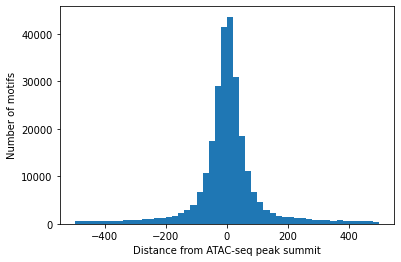

In [221]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

data_n.hist(column=5,bins=50,grid=False)
#plt.axvline(x=-846//2, color='r', linestyle='-')
#plt.axvline(x=846//2, color='r', linestyle='-')

plt.xlabel("Distance from ATAC-seq peak summit")
plt.ylabel("Number of motifs")
plt.title("")

plt.savefig("subfigs/motif_density_around_summit_k562_atac.pdf", dpi=300, transparent=True)


In [ ]:
peak_table_orig = pd.read_csv(
        peak_bed_path, sep="\t", header=None, index_col=False
    )

In [ ]:
np.mean((peak_table_orig[2]-peak_table_orig[1]))

In [ ]:
motif_density = data.groupby([4]).size()

In [ ]:
accessibility = data.groupby([4])[6].mean()

In [ ]:
merged = accessibility.to_frame().join(motif_density.to_frame())


In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.log(merged[6]),merged[0])

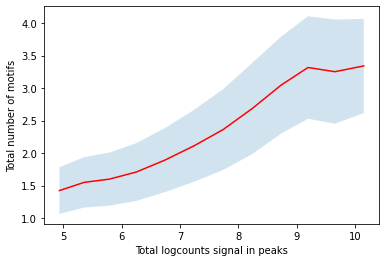

In [158]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

def equal_bin_v2(N, m):
    idx = np.linspace(0,m,N.size, endpoint=0).astype(int)
    return idx[N.argsort().argsort()]  

#bins = np.linspace(0, 12, 10)
#digitized = np.digitize(np.log(pval_signal), bins)
#bin_means = [np.mean(np.array(jaccard_scores)[digitized == i]) for i in range(1, len(bins))]

#idxs = equal_bin_v2(np.log(merged[6]), 10)
bins = np.linspace(4, 11, 15)
idxs = np.digitize(np.log(merged[6]), bins)

bin_vals = [np.mean(np.array(merged[0])[idxs == i]) for i in range(2, max(idxs))]
bin_means = [np.mean(np.array(merged[0])[idxs == i]) for i in range(2, max(idxs))]

pval_means = [np.mean(np.log(merged[6])[idxs == i]) for i in range(2, max(idxs))]
bin_std = [np.std(np.array(merged[0])[idxs == i]) for i in range(2, max(idxs))]

#bin_std1 = [np.quantile(np.array(merged[0])[idxs == i],0.25) for i in range(2, max(idxs))]
#bin_std2 = [np.quantile(np.array(merged[0])[idxs == i],0.75) for i in range(2, max(idxs))]

#plt.boxplot(bin_vals,showfliers=False,showmeans=True)
#plt.ylim((0,6))
#plt.errorbar(pval_means, bin_means, yerr=bin_std, fmt='o')
#len(pval_means)

plt.plot(pval_means, bin_means, 'r-')
plt.fill_between(pval_means, bin_means-(np.array(bin_std)/2), bin_means+(np.array(bin_std)/2),alpha=0.2)
plt.xlabel("Total logcounts signal in peaks")
plt.ylabel("Total number of motifs")

plt.savefig("subfigs/motif_density_with_accessibility_k562_atac.pdf", dpi=300, transparent=True)

plt.show()


In [159]:

data = pd.read_csv("addons/hits_filtered_bed_k562_atac.clustered.bed",sep="\t",header=None)

data.head()

,0,1,2,3,4,5,6,7
0,chr1,41372,41377,0_0_GATA3_GATA_1,24261,-227.5,322.0,1
1,chr1,41372,41377,0_0_GATA3_GATA_1,24082,283.5,425.0,1
2,chr1,42187,42192,0_0_GATA3_GATA_1,24322,-90.5,326.0,2
3,chr1,42279,42289,0_3_BACH2_HUMAN.H11MO.0.A,24322,4.0,326.0,3
4,chr1,42334,42339,0_0_GATA3_GATA_1,24322,56.5,326.0,4


In [189]:
peaks_signal = []
motifs_in_peaks_distance = []
peaks_ids = []
for i,r in data.iterrows():
    if r[4] in peaks_ids:
        continue
    peaks_ids.append(r[4])
    peaks_signal.append(r[6])
    motifs_distances = list(set(data[data[4]==r[4]][5]))
    sorted_dist = np.sort(motifs_distances)
    values = []
    
    if len(sorted_dist) == 1:
        right_clust = data[data[7]==r[7]-1]
        left_clust = data[data[7]==r[7]+1]

        motifs_in_peaks_distance.append(values)
        continue
        #if len(right_clust[0].values) > 0:
        #    if right_clust[0].values[0] == r[0]:
        #        values.append(np.abs(((right_clust[1].values[0]+right_clust[2].values[0])/2)-((r[1]+r[2])/2)))
        #if len(left_clust[0].values) > 0:
        #    if left_clust[0].values[0] == r[0]:
        #        values.append(np.abs(((left_clust[1].values[0]+left_clust[2].values[0])/2)-((r[1]+r[2])/2)))
                #print(values[-1])
    
    for jd in range(1,len(sorted_dist)):
        values.append(sorted_dist[jd] - sorted_dist[jd-1])
        if (sorted_dist[jd] - sorted_dist[jd-1]) <0:
            print(sorted_dist)
        #print(values[-1])
    motifs_in_peaks_distance.append(np.mean(values))
        
        

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

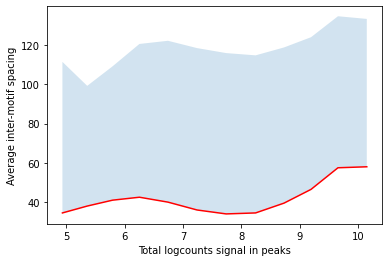

In [190]:
import matplotlib
import matplotlib.pyplot as plt
from itertools import chain

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

def equal_bin_v2(N, m):
    idx = np.linspace(0,m,N.size, endpoint=0).astype(int)
    return idx[N.argsort().argsort()]  

#bins = np.linspace(0, 12, 10)
#digitized = np.digitize(np.log(pval_signal), bins)
#bin_means = [np.mean(np.array(jaccard_scores)[digitized == i]) for i in range(1, len(bins))]

#idxs = equal_bin_v2(np.log(merged[6]), 10)
bins = np.linspace(4, 11, 15)
idxs = np.digitize(np.log(peaks_signal), bins)

bin_vals = [np.mean(list(chain.from_iterable(np.array(motifs_in_peaks_distance)[idxs == i].tolist()))) for i in range(2, max(idxs))]
bin_means = [np.median(list(chain.from_iterable(np.array(motifs_in_peaks_distance)[idxs == i].tolist()))) for i in range(2, max(idxs))]

pval_means = [np.mean(np.log(peaks_signal)[idxs == i]) for i in range(2, max(idxs))]
bin_std = [np.std(list(chain.from_iterable(np.array(motifs_in_peaks_distance)[idxs == i].tolist()))) for i in range(2, max(idxs))]


#bin_std1 = [np.quantile(np.array(merged[0])[idxs == i],0.25) for i in range(2, max(idxs))]
#bin_std2 = [np.quantile(np.array(merged[0])[idxs == i],0.75) for i in range(2, max(idxs))]

#plt.boxplot(bin_vals,showfliers=False,showmeans=True)
#plt.ylim((0,6))
#plt.errorbar(pval_means, bin_means, yerr=bin_std, fmt='o')
#len(pval_means)

plt.plot(pval_means, bin_means, 'r-')
plt.fill_between(pval_means, bin_means, bin_means+(np.array(bin_std)/2),alpha=0.2)
plt.xlabel("Total logcounts signal in peaks")
plt.ylabel("Average inter-motif spacing")

#plt.savefig("subfigs/motif_density_with_accessibility_k562_atac.pdf", dpi=300, transparent=True)

plt.show()


In [ ]:
data

In [170]:
motifs_in_peaks_distance[5]

[1774.0, 9570.0]

In [235]:
#output = list(chain.from_iterable(np.array(motifs_in_peaks_distance)))
output = list([np.median(x) for x in np.array(motifs_in_peaks_distance)])

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/anusri/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


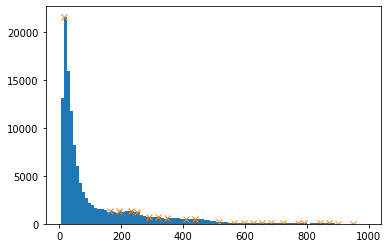

In [249]:
plt.hist(output,bins=100)
plt.plot(bin_edges[peaks],hist[peaks],"x")

In [246]:
output=np.array(output)
output = output[~np.isnan(output)]

hist, bin_edges = np.histogram(output, 100)


In [247]:
import scipy.signal
peaks, _ = scipy.signal.find_peaks(hist)


In [248]:
bin_edges[peaks]

array([ 14.84, 162.44, 191.96, 231.32, 251.  , 290.36, 319.88, 349.4 ,
       408.44, 437.96, 516.68, 565.88, 595.4 , 624.92, 654.44, 683.96,
       723.32, 772.52, 792.2 , 841.4 , 870.92, 900.44, 949.64])